In [1]:
# 1. Imports
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import optuna

# modeling
from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from scipy.special import logit, expit
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix

# PyTorch for conversion model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# nfl pbp loader
import nfl_data_py as nfl

# reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# 2a. Download PBP (this can take a few minutes)
seasons = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2024]
print("Loading play-by-play for seasons:", seasons)
raw_pbp = nfl.import_pbp_data(seasons, downcast=False)  # returns a DataFrame (may be large)

print("Rows loaded:", raw_pbp.shape[0])
raw_pbp.head()

Loading play-by-play for seasons: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2024]
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2024 done.
Rows loaded: 433940


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,was_pressure,route,defense_man_zone_type,defense_coverage_type,offense_names,defense_names,offense_positions,defense_positions,offense_numbers,defense_numbers
0,1.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,51.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,75.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,96.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def parse_weather(weather_str):
    """
    Parses a weather string into structured features:
        - temp_F: float
        - humidity: float (percentage)
        - wind_mph: float
        - wind_dir: str
        - conditions: str (general description, e.g., 'sunny', 'cloudy', etc.)
    """
    result = {
        "temp_F": None,
        "humidity": None,
        "wind_mph": None,
        "wind_dir": None,
        "conditions": None
    }
    
    if not isinstance(weather_str, str):
        return result
    
    lower_str = weather_str.lower()
    
    # Extract temperature
    temp_match = re.search(r'(\d+)\s*°?\s*f', lower_str)
    if temp_match:
        result['temp_F'] = float(temp_match.group(1))
    
    # Extract humidity
    hum_match = re.search(r'humidity[:\s]*(\d+)%', lower_str)
    if hum_match:
        result['humidity'] = float(hum_match.group(1))
    
    # Extract wind speed and direction
    wind_match = re.search(r'wind[:\s]*([nesw]+)\s*(\d+)\s*mph', lower_str)
    if wind_match:
        result['wind_dir'] = wind_match.group(1).upper()
        result['wind_mph'] = float(wind_match.group(2))
    
    # Extract general conditions
    conditions = []
    for cond in ['sunny', 'cloudy', 'clear', 'rain', 'snow', 'fog', 'drizzle', 'storm', 'windy']:
        if cond in lower_str:
            conditions.append(cond)
    if conditions:
        result['conditions'] = ','.join(conditions)
    
    return result


def deconstruct_weather(df, weather_col='weather'):
    """
    Adds structured weather columns to a DataFrame based on a weather string column.
    
    New columns added:
      - temp_F
      - humidity
      - wind_mph
      - wind_dir
      - conditions
    """
    weather_data = df[weather_col].apply(parse_weather)
    weather_df = pd.DataFrame(weather_data.tolist())
    df = pd.concat([df.reset_index(drop=True), weather_df], axis=1)
    
    # Fill missing wind speeds with 0
    df['wind_mph'] = df['wind_mph'].fillna(0)

    # Fill missing temperatures with 60°F
    df['temp_F'] = df['temp_F'].fillna(60)

    return df

In [4]:
cols_to_keep = ['play_type', 'play_type_actual', 'season', 'home_wp_post', 'away_wp_post', 'weather', 'yardline_100', 'ydstogo',
               'game_seconds_remaining', 'half_seconds_remaining', 'posteam', 'defteam',
               'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'kick_distance', 'touchback',
                'return_yards', 'first_down', 'touchdown', 'temp_F', 'wind_mph', 'game_id', 'score_differential',
                'home_team', 'away_team', 'home_score', 'away_score', 'down', 'field_goal_result', 'penalty']

In [5]:
pbp = raw_pbp.copy()

action_to_col = {
    "punt": "punt",
    "field_goal": "field_goal",
    "run": "go",
    "pass": "go"
}

pbp["play_type_actual"] = pbp["play_type"].map(action_to_col)
pbp = pbp[pbp.play_type_actual.isin(['punt', 'go', 'field_goal'])]
pbp = deconstruct_weather(pbp)
pbp = pbp[cols_to_keep].copy()
pbp = pbp[pbp.penalty == 0]
pbp['fg_made'] = (pbp["field_goal_result"] == "made").astype(int)

action_to_ewp_col = {
    "punt": "ewp_punt",
    "field_goal": "ewp_fg",
    "go": "ewp_go_adj"
}
pbp["actual_ewp_col"] = pbp["play_type_actual"].map(action_to_ewp_col)

In [6]:
seasons = pbp.season.unique() # seasons
test_season = seasons.max()

pbp_train = pbp[pbp.season != test_season]
pbp_test = pbp[pbp.season == test_season]

In [7]:
def make_temporal_folds(df, season_col="season", min_train_seasons=3):
    """
    Expanding-window CV folds by season.
    Returns list of (train_idx, val_idx).
    """
    seasons = np.sort(df[season_col].unique())
    folds = []

    for i in range(min_train_seasons, len(seasons)):
        train_seasons = seasons[:i]
        val_season = seasons[i]

        train_idx = df[df[season_col].isin(train_seasons)].index
        val_idx = df[df[season_col] == val_season].index

        folds.append((train_idx, val_idx))

    return folds

In [14]:
# --- Drop rows missing home/away WP
wp_df = pbp_train.dropna(subset=["home_wp_post", "away_wp_post"]).copy()

# --- Define features
wp_df["score_time_ratio"] = wp_df["score_differential"].abs() / (wp_df["game_seconds_remaining"] + 1)
wp_features = [
    "yardline_100",
    "down",
    "ydstogo",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "score_time_ratio",
    "temp_F",
    "wind_mph"
]

# --- Define posteam WP target
wp_df["wp_target"] = np.where(
    wp_df["posteam"] == wp_df["home_team"],
    wp_df["home_wp_post"],
    wp_df["away_wp_post"]
)

wp_df = wp_df.reset_index(drop=True)

X_wp = wp_df[wp_features]
y_wp = wp_df["wp_target"]

# --- Clip target to avoid exact 0/1 ---
epsilon = 1e-6
y_wp_clipped = y_wp.clip(epsilon, 1 - epsilon).reset_index(drop=True)

# --- Monotone constraints
monotone_constraints_dict = {
    "yardline_100": -1,               # closer to opponent endzone → WP ↑
    "down": -1,                       # higher down (worse) → WP ↓
    "ydstogo": -1,                    # more yards to go → WP ↓
    "score_differential": 1,          # lead → WP ↑
    "posteam_timeouts_remaining": 1,  # more TOs → WP ↑
    "defteam_timeouts_remaining": -1  # opponent TOs → WP ↓
}

wp_folds = make_temporal_folds(wp_df)

In [15]:
def wp_objective(trial):

    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 5),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.08),
        "n_estimators": trial.suggest_int("n_estimators", 200, 400),
        "subsample": trial.suggest_float("subsample", 0.7, 0.9),
        "min_child_weight": trial.suggest_int("min_child_weight", 20, 100),
        "verbosity": 0,
        "monotone_constraints": monotone_constraints_dict,
        "early_stopping_rounds": 10,
        "eval_metric": "rmse",
    }

    rmses = []

    for train_idx, val_idx in wp_folds:
        X_train, X_val = X_wp.iloc[train_idx], X_wp.iloc[val_idx]
        y_train, y_val = y_wp_clipped.iloc[train_idx], y_wp_clipped.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        preds = model.predict(X_val)
        rmse = mean_squared_error(y_val, preds, squared=False)
        rmses.append(rmse)

    return np.mean(rmses)

In [16]:
wp_study = optuna.create_study(direction="minimize")
wp_study.optimize(wp_objective, n_trials=100)

[I 2026-01-07 16:08:17,459] A new study created in memory with name: no-name-e167f7eb-99ec-4f48-bf67-a25537242e1b
[I 2026-01-07 16:08:33,021] Trial 0 finished with value: 0.062168508286401566 and parameters: {'max_depth': 4, 'learning_rate': 0.024657945234489234, 'n_estimators': 202, 'subsample': 0.7285203755177189, 'min_child_weight': 65}. Best is trial 0 with value: 0.062168508286401566.
[I 2026-01-07 16:08:49,559] Trial 1 finished with value: 0.06042567062265038 and parameters: {'max_depth': 4, 'learning_rate': 0.04888092506173167, 'n_estimators': 202, 'subsample': 0.8939986578947132, 'min_child_weight': 30}. Best is trial 1 with value: 0.06042567062265038.
[I 2026-01-07 16:09:13,140] Trial 2 finished with value: 0.05991476460859744 and parameters: {'max_depth': 4, 'learning_rate': 0.05563815423681023, 'n_estimators': 296, 'subsample': 0.8899655836907474, 'min_child_weight': 21}. Best is trial 2 with value: 0.05991476460859744.
[I 2026-01-07 16:09:45,076] Trial 3 finished with value

[I 2026-01-07 16:19:13,856] Trial 28 finished with value: 0.05937703631221701 and parameters: {'max_depth': 5, 'learning_rate': 0.06435224066497693, 'n_estimators': 369, 'subsample': 0.7143808610248835, 'min_child_weight': 29}. Best is trial 28 with value: 0.05937703631221701.
[I 2026-01-07 16:19:41,776] Trial 29 finished with value: 0.05984337268884258 and parameters: {'max_depth': 4, 'learning_rate': 0.05028740692564544, 'n_estimators': 383, 'subsample': 0.7228147319908695, 'min_child_weight': 29}. Best is trial 28 with value: 0.05937703631221701.
[I 2026-01-07 16:20:07,837] Trial 30 finished with value: 0.05940424570864287 and parameters: {'max_depth': 5, 'learning_rate': 0.05694712478929735, 'n_estimators': 369, 'subsample': 0.736751098840853, 'min_child_weight': 22}. Best is trial 28 with value: 0.05937703631221701.
[I 2026-01-07 16:20:32,606] Trial 31 finished with value: 0.05946859994241795 and parameters: {'max_depth': 5, 'learning_rate': 0.05852915405729175, 'n_estimators': 36

[I 2026-01-07 16:32:47,886] Trial 57 finished with value: 0.05950977332072549 and parameters: {'max_depth': 5, 'learning_rate': 0.04171643694442837, 'n_estimators': 312, 'subsample': 0.7584402648302315, 'min_child_weight': 59}. Best is trial 33 with value: 0.05931890543232501.
[I 2026-01-07 16:33:19,028] Trial 58 finished with value: 0.059420132404991666 and parameters: {'max_depth': 5, 'learning_rate': 0.04539858782498231, 'n_estimators': 341, 'subsample': 0.8107601081697299, 'min_child_weight': 41}. Best is trial 33 with value: 0.05931890543232501.
[I 2026-01-07 16:33:45,741] Trial 59 finished with value: 0.05939311469834332 and parameters: {'max_depth': 5, 'learning_rate': 0.05779062316335163, 'n_estimators': 351, 'subsample': 0.718523107886798, 'min_child_weight': 25}. Best is trial 33 with value: 0.05931890543232501.
[I 2026-01-07 16:34:12,096] Trial 60 finished with value: 0.05937446705266784 and parameters: {'max_depth': 5, 'learning_rate': 0.06065407368457592, 'n_estimators': 3

[I 2026-01-07 16:46:02,126] Trial 86 finished with value: 0.05940729304343888 and parameters: {'max_depth': 5, 'learning_rate': 0.05023188930018173, 'n_estimators': 384, 'subsample': 0.7262294696522399, 'min_child_weight': 37}. Best is trial 33 with value: 0.05931890543232501.
[I 2026-01-07 16:46:30,180] Trial 87 finished with value: 0.05935683568850927 and parameters: {'max_depth': 5, 'learning_rate': 0.05375856328922013, 'n_estimators': 371, 'subsample': 0.7220357817872775, 'min_child_weight': 30}. Best is trial 33 with value: 0.05931890543232501.
[I 2026-01-07 16:46:59,046] Trial 88 finished with value: 0.05942046296163676 and parameters: {'max_depth': 5, 'learning_rate': 0.05383285317348861, 'n_estimators': 393, 'subsample': 0.8657143164410024, 'min_child_weight': 35}. Best is trial 33 with value: 0.05931890543232501.
[I 2026-01-07 16:47:28,797] Trial 89 finished with value: 0.05944411929521572 and parameters: {'max_depth': 5, 'learning_rate': 0.0424712094711175, 'n_estimators': 33

In [17]:
best_params = wp_study.best_params
best_score = wp_study.best_value

print("Best CV RMSE:", best_score)
print("Best params:", best_params)

Best CV RMSE: 0.05931890543232501
Best params: {'max_depth': 5, 'learning_rate': 0.052245367633045534, 'n_estimators': 367, 'subsample': 0.7365164365547575, 'min_child_weight': 28}


In [18]:
# Add monotone constraints if not in params already
best_params["monotone_constraints"] = monotone_constraints_dict
best_params["verbosity"] = 0

wp_model = XGBRegressor(**best_params)
wp_model.fit(X_wp, y_wp_clipped)  # Train on full dataset


def predict_wp(state_df):
    """
    Returns win probability for the team with possession in state_df.
    All EWPs are reported from the perspective of the pre-play offensive team.
    Therefore:
        - Use predict_wp(...) if possession is retained
        - Use 1 - predict_wp(...) if possession flips
    """
    
    if "score_time_ratio" not in state_df:
        state_df["score_time_ratio"] = state_df["score_differential"].abs() / (state_df["game_seconds_remaining"] + 1)
    preds = wp_model.predict(state_df[wp_features])
    return np.clip(preds, 0.0, 1.0)

In [19]:
def wp_symmetric_adjust(state_df, predict_wp):
    # Predict from original perspective
    wp = predict_wp(state_df)

    # Create flipped states
    state_flipped = state_df.copy()
    state_flipped["score_differential"] *= -1
    state_flipped[["posteam_timeouts_remaining", "defteam_timeouts_remaining"]] = \
        state_flipped[["defteam_timeouts_remaining", "posteam_timeouts_remaining"]].values
    state_flipped["yardline_100"] = 100 - state_flipped["yardline_100"]
    state_flipped["score_time_ratio"] = state_df["score_time_ratio"]
    
    wp_flipped = predict_wp(state_flipped)

    # Symmetric adjustment
    wp_sym = 0.5 * (wp + (1 - wp_flipped))
    
    # Weighting
    sym_weighting = 0.20
    
    return (1 - sym_weighting) * wp + sym_weighting * wp_sym

In [20]:
# Create punt_df with only punt plays
punt_df = pbp_train[pbp_train.play_type_actual == "punt"].dropna(subset=["kick_distance", "return_yards"]).copy()

# Compute net punt yardage: kick distance minus return yards, adjust for touchbacks (if available)
# Assuming touchback puts ball at 20-yard line
punt_df["net_punt"] = punt_df["kick_distance"] - punt_df["return_yards"]
punt_df.loc[punt_df["touchback"] == 1, "net_punt"] = punt_df["yardline_100"] - 20

# Reset index to avoid any issues
punt_df = punt_df.reset_index(drop=True)

# Make temporal folds based on seasons in punt_df
punt_folds = make_temporal_folds(punt_df, season_col="season", min_train_seasons=3)

# Features to predict net punt
punt_df["score_time_ratio"] = punt_df["score_differential"].abs() / (punt_df["game_seconds_remaining"] + 1)
punt_features = [
    "yardline_100", 
    "game_seconds_remaining", 
    "half_seconds_remaining",
    "score_differential",
    "score_time_ratio",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "temp_F",
    "wind_mph"
]

X_punt = punt_df[punt_features].values
y_punt = punt_df["net_punt"].values

X_scaler = StandardScaler()
X_punt_scaled = X_scaler.fit_transform(X_punt)

y_scaler = StandardScaler()
y_punt_scaled = y_scaler.fit_transform(y_punt.reshape(-1,1))

In [21]:
def punt_objective(trial):
    
    # Suggest hyperparameters
    n_layers = trial.suggest_int("n_layers", 1, 3)
    hidden_size = trial.suggest_int("hidden_size", 16, 128)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.5)
    epochs = 50

    rmses = []

    # Loop over temporal folds
    for train_idx, val_idx in punt_folds:
        # Prepare fold data
        X_train = torch.tensor(X_punt_scaled[train_idx], dtype=torch.float32)
        y_train = torch.tensor(y_punt_scaled[train_idx], dtype=torch.float32)
        X_val = torch.tensor(X_punt_scaled[val_idx], dtype=torch.float32)
        y_val = torch.tensor(y_punt_scaled[val_idx], dtype=torch.float32)

        input_dim = X_train.shape[1]

        # Build the network
        layers = []
        for i in range(n_layers):
            layers.append(nn.Linear(input_dim if i == 0 else hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_size, 1))
        
        model = nn.Sequential(*layers)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Training loop
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val)
            val_loss = criterion(val_preds, y_val).item()
            rmses.append(np.sqrt(val_loss))

    # Return mean RMSE across folds
    return np.mean(rmses)

In [22]:
punt_study = optuna.create_study(direction="minimize")
punt_study.optimize(punt_objective, n_trials=25)

[I 2026-01-07 16:52:15,602] A new study created in memory with name: no-name-660eb9f8-5480-40f2-9fdc-0e15288db303
[I 2026-01-07 16:52:16,196] Trial 0 finished with value: 0.9643955546818083 and parameters: {'n_layers': 1, 'hidden_size': 18, 'lr': 0.001322649297801665, 'dropout': 0.2462340169764567}. Best is trial 0 with value: 0.9643955546818083.
[I 2026-01-07 16:52:17,396] Trial 1 finished with value: 0.9136988469321692 and parameters: {'n_layers': 2, 'hidden_size': 24, 'lr': 0.008875031258353447, 'dropout': 0.0023696617198185055}. Best is trial 1 with value: 0.9136988469321692.
[I 2026-01-07 16:52:20,389] Trial 2 finished with value: 0.9782423040991576 and parameters: {'n_layers': 3, 'hidden_size': 37, 'lr': 0.00010388080330793555, 'dropout': 0.021638699931807948}. Best is trial 1 with value: 0.9136988469321692.
[I 2026-01-07 16:52:26,473] Trial 3 finished with value: 0.9142060423579226 and parameters: {'n_layers': 3, 'hidden_size': 92, 'lr': 0.0010119642396970961, 'dropout': 0.16492

In [23]:
best_params = punt_study.best_params
best_score = punt_study.best_value
n_layers = best_params["n_layers"]
hidden_size = best_params["hidden_size"]
dropout_rate = best_params["dropout"]
lr = best_params["lr"]

print("Best CV RMSE:", best_score)
print("Best params:", best_params)

Best CV RMSE: 0.9121370428464269
Best params: {'n_layers': 2, 'hidden_size': 117, 'lr': 0.002743600977936449, 'dropout': 0.14117088643298423}


In [24]:
# Build final model
layers = []
input_dim = X_punt_scaled.shape[1]
for i in range(n_layers):
    layers.append(nn.Linear(input_dim if i==0 else hidden_size, hidden_size))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(dropout_rate))
layers.append(nn.Linear(hidden_size, 1))
punt_model = nn.Sequential(*layers)

# Convert full data to tensors
X_t = torch.tensor(X_punt_scaled, dtype=torch.float32)
y_t = torch.tensor(y_punt_scaled, dtype=torch.float32)

optimizer = torch.optim.Adam(punt_model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

# Train final model
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    preds = punt_model(X_t)
    loss = loss_fn(preds, y_t)
    loss.backward()
    optimizer.step()

In [25]:
# --- Filter to field goal attempts only ---
fg_df = pbp_train[pbp_train.play_type_actual == "field_goal"].dropna(subset=["field_goal_result"]).copy()
fg_df = fg_df[fg_df.field_goal_result.isin(['made', 'missed', 'blocked'])]

# Field goal
fg_df["score_time_ratio"] = fg_df["score_differential"].abs() / (fg_df["game_seconds_remaining"] + 1)
fg_features = [
    "yardline_100",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "score_time_ratio",
    "temp_F",
    "wind_mph"
]

X_fg = fg_df[fg_features]
y_fg = fg_df["fg_made"]

fg_folds = make_temporal_folds(
    fg_df,
    season_col="season",
    min_train_seasons=3
)

fg_oof_pred = pd.Series(index=fg_df.index, dtype=float)
fg_df["fg_make_prob_oof"] = fg_oof_pred

for fold_num, (train_idx, val_idx) in enumerate(fg_folds, 1):
    X_train = X_fg.loc[train_idx]
    y_train = y_fg.loc[train_idx]
    X_val   = X_fg.loc[val_idx]

    fg_model_lr_fold = LogisticRegression(
        solver="lbfgs",
        max_iter=1000
    )

    fg_model_lr_fold.fit(X_train, y_train)

    fg_oof_pred.loc[val_idx] = fg_model_lr_fold.predict_proba(X_val)[:, 1]

mask = fg_oof_pred.notna()
fg_oof_rmse = np.sqrt(np.mean((fg_oof_pred[mask] - y_fg[mask]) ** 2))
print("FG (LogReg) OOF RMSE:", fg_oof_rmse)

fg_model = LogisticRegression(
    solver="lbfgs",
    max_iter=1000
)

fg_model.fit(X_fg, y_fg)

FG (LogReg) OOF RMSE: 0.3396162398418047


LogisticRegression(max_iter=1000)

In [26]:
max_fg = 65
fg_decay_threshold = 60

In [27]:
# Filter to 4th-down go-for-it plays
go_df = pbp_train[
    (pbp_train['down'] == 4) &
    (pbp_train['play_type_actual'] == 'go')  # filters out punts/FGs
].copy()

# Target: did the team convert?
go_df = go_df.dropna(subset=['first_down'])

# Go-for-it conversion
go_df["score_time_ratio"] = go_df["score_differential"].abs() / (go_df["game_seconds_remaining"] + 1)

go_df["success"] = (
    (go_df["first_down"] == 1) |
    (go_df["touchdown"] == 1)
).astype(int)

# Reset index to avoid any issues
go_df = go_df.reset_index(drop=True)

# Make temporal folds based on seasons in punt_df
go_folds = make_temporal_folds(go_df, season_col="season", min_train_seasons=3)

# Features to predict net punt
go_features = [
    "yardline_100",
    "ydstogo",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "score_time_ratio",
    "temp_F",
    "wind_mph"
]

X_go = go_df[go_features].values
y_go = go_df["success"].values

In [28]:
monotone_constraints = [
    -1,  # yardline_100 (farther → worse)
    -1,  # ydstogo (longer → worse)
    0,   # game_seconds_remaining
    0,   # half_seconds_remaining
    1,   # score_differential
    0,   # posteam_timeouts_remaining
    0,   # defteam_timeouts_remaining
    -1,  # score_time_ratio
    0,   # temp_F
    0    # wind_mph
]

def go_objective(trial):
    # Suggest hyperparameters
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "objective": "binary:logistic",
        "monotone_constraints": tuple(monotone_constraints),
        "eval_metric": "logloss",
        "use_label_encoder": False
    }

    log_losses = []

    for train_idx, val_idx in go_folds:
        X_train, X_val = X_go[train_idx], X_go[val_idx]  # no scaler
        y_train, y_val = y_go[train_idx], y_go[val_idx]

        model = XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        preds = model.predict_proba(X_val)[:, 1]
        log_losses.append(log_loss(y_val, preds))

    return np.mean(log_losses)

In [29]:
# Run Optuna search
go_study = optuna.create_study(direction="minimize")
go_study.optimize(go_objective, n_trials=25)

[I 2026-01-07 16:54:21,539] A new study created in memory with name: no-name-55a23778-4e40-40e0-9e75-b274d8630ecb
[I 2026-01-07 16:54:38,622] Trial 0 finished with value: 0.6624077675961272 and parameters: {'max_depth': 8, 'learning_rate': 0.0056816096093601975, 'n_estimators': 207, 'subsample': 0.8551148960617043, 'colsample_bytree': 0.5090316494435257}. Best is trial 0 with value: 0.6624077675961272.
[I 2026-01-07 16:54:42,217] Trial 1 finished with value: 0.6853172112219019 and parameters: {'max_depth': 3, 'learning_rate': 0.0011663732012460297, 'n_estimators': 109, 'subsample': 0.6624525691623847, 'colsample_bytree': 0.808111322150183}. Best is trial 0 with value: 0.6624077675961272.
[I 2026-01-07 16:55:11,864] Trial 2 finished with value: 0.6616940509166577 and parameters: {'max_depth': 10, 'learning_rate': 0.006710012092556256, 'n_estimators': 285, 'subsample': 0.6584882637053185, 'colsample_bytree': 0.5626906600935463}. Best is trial 2 with value: 0.6616940509166577.
[I 2026-01-

In [30]:
# Train final model with best hyperparameters
best_params = go_study.best_trial.params
best_params["monotone_constraints"] = tuple(monotone_constraints)
best_params["use_label_encoder"] = False
best_params["eval_metric"] = "logloss"

# Compute class imbalance weight
pos = (y_go == 1).sum()
neg = (y_go == 0).sum()
scale_pos_weight = neg / pos

go_model = XGBClassifier(**best_params, scale_pos_weight=scale_pos_weight)
go_model.fit(X_go, y_go)  # feed raw features, no scaling

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8423772838274479, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.009303747988775252,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan,
              monotone_constraints=(-1, -1, 0, 0, 1, 0, 0, -1, 0, 0),
              multi_strategy=None, n_estimators=391, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [31]:
def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

In [32]:
def go_success_state_penalty(ydstogo, wp_current, game_seconds_remaining, center=6, scale=3.5, time_scale=900):
    """
    Returns a bounded WP penalty applied to successful go-for-it attempts,
    capturing execution fragility on long conversions.
    """
    y = np.asarray(ydstogo, dtype=float)
    wp = np.asarray(wp_current, dtype=float)
    t = np.asarray(game_seconds_remaining, dtype=float)

    # Distance-based ramp: flat → steep → flat
    dist_ramp = sigmoid((y - center) / scale)

    # WP weighting: strongest near 0.5, fades near 0 or 1
    wp_weight = 1 - 4 * (wp - 0.5) ** 2
    wp_weight = np.clip(wp_weight, 0, 1)

    # Time weighting: fades late in the game
    time_weight = np.clip(t / time_scale, 0, 1)

    return dist_ramp * wp_weight * time_weight

In [33]:
def sigmoid_penalty(y, center, scale):
    
    y = np.asarray(y, dtype=float)
    ramp = sigmoid((y - center) / scale) # ~0 for y << center, ~1 for y >> center

    return ramp

In [34]:
def scoring_possessions_to_tie(score_differential):
    
    score_diff = np.asarray(score_differential)

    return np.where(score_diff < 0, np.ceil(np.abs(score_diff) / 8), 0)

In [35]:
def create_plays_df(df):
    
    # Compute final scores and win from offensive team perspective
    final_scores = (
        df.groupby("game_id")
           .tail(1)[["game_id","home_team","away_team","home_score","away_score"]]
           .copy()
    )
    final_scores["home_win"] = (final_scores["home_score"] > final_scores["away_score"]).astype(int)

    df = df.merge(final_scores[["game_id","home_win"]], on="game_id", how="left")
    df["win_actual"] = np.where(
        df["posteam"] == df["home_team"],
        df["home_win"],
        1 - df["home_win"]
    )
    
    return df

In [36]:
def create_next_fg_conv_states(df):
    
    # Next state if successful field goal attempt
    df['fg_success_yardline_100'] = 75
    df['fg_success_down'] = 1
    df['fg_success_ydstogo'] = 10
    df['fg_success_game_seconds_remaining'] = np.maximum(0, df['game_seconds_remaining'] - 5)
    df['fg_success_half_seconds_remaining'] = np.maximum(0, df['half_seconds_remaining'] - 5)
    df['fg_success_score_differential'] = -(df['score_differential'] + 3)
    df['fg_success_posteam_timeouts_remaining'] = df['defteam_timeouts_remaining']
    df['fg_success_defteam_timeouts_remaining'] = df['posteam_timeouts_remaining']
    df['fg_success_score_time_ratio'] = df['fg_success_score_differential'].abs() / (df['fg_success_game_seconds_remaining'] + 1)
    df['fg_success_temp_F'] = df['temp_F']
    df['fg_success_wind_mph'] = df['wind_mph']
    
    # Next state if failed field goal attempt
    df['fg_fail_yardline_100'] = 100 - (df['yardline_100'] + 7)
    df['fg_fail_down'] = 1
    df['fg_fail_ydstogo'] = 10
    df['fg_fail_game_seconds_remaining'] = np.maximum(0, df['game_seconds_remaining'] - 5)
    df['fg_fail_half_seconds_remaining'] = np.maximum(0, df['half_seconds_remaining'] - 5)
    df['fg_fail_score_differential'] = -df['score_differential']
    df['fg_fail_posteam_timeouts_remaining'] = df['defteam_timeouts_remaining']
    df['fg_fail_defteam_timeouts_remaining'] = df['posteam_timeouts_remaining']
    df['fg_fail_score_time_ratio'] = df['fg_fail_score_differential'].abs() / (df['fg_fail_game_seconds_remaining'] + 1)
    df['fg_fail_temp_F'] = df['temp_F']
    df['fg_fail_wind_mph'] = df['wind_mph']
    
    # Next state if successful conversion attempt
    df['go_success_yardline_100'] = df['yardline_100'] - df['ydstogo']
    df['go_success_down'] = 1
    df['go_success_ydstogo'] = np.minimum(10, df['go_success_yardline_100'])
    df['go_success_game_seconds_remaining'] = np.maximum(0, df['game_seconds_remaining'] - 5)
    df['go_success_half_seconds_remaining'] = np.maximum(0, df['half_seconds_remaining'] - 5)
    df['go_success_score_differential'] = df['score_differential']
    df['go_success_posteam_timeouts_remaining'] = df['posteam_timeouts_remaining']
    df['go_success_defteam_timeouts_remaining'] = df['defteam_timeouts_remaining']
    df['go_success_score_time_ratio'] = df['go_success_score_differential'].abs() / (df['go_success_game_seconds_remaining'] + 1)
    df['go_success_temp_F'] = df['temp_F']
    df['go_success_wind_mph'] = df['wind_mph']
    
    # Next state if failed conversion attempt
    df['go_fail_yardline_100'] = 100 - df['yardline_100']
    df['go_fail_down'] = 1
    df['go_fail_ydstogo'] = 10
    df['go_fail_game_seconds_remaining'] = np.maximum(0, df['game_seconds_remaining'] - 5)
    df['go_fail_half_seconds_remaining'] = np.maximum(0, df['half_seconds_remaining'] - 5)
    df['go_fail_score_differential'] = -df['score_differential']
    df['go_fail_posteam_timeouts_remaining'] = df['defteam_timeouts_remaining']
    df['go_fail_defteam_timeouts_remaining'] = df['posteam_timeouts_remaining']
    df['go_fail_score_time_ratio'] = df['go_fail_score_differential'].abs() / (df['go_fail_game_seconds_remaining'] + 1)
    df['go_fail_temp_F'] = df['temp_F']
    df['go_fail_wind_mph'] = df['wind_mph']
    
    return df

In [37]:
def calculate_ewp_fg(df):
    
    if "down" in df.columns:
        fourth_down_mask = df["down"] == 4
    else:
        fourth_down_mask = pd.Series(True, index=df.index)

    X_fg_success = df.loc[fourth_down_mask, [
        "fg_success_yardline_100",
        "fg_success_down",
        "fg_success_ydstogo",
        "fg_success_game_seconds_remaining",
        "fg_success_half_seconds_remaining",
        "fg_success_score_differential",
        "fg_success_posteam_timeouts_remaining",
        "fg_success_defteam_timeouts_remaining",
        "fg_success_score_time_ratio",
        "fg_success_temp_F",
        "fg_success_wind_mph"
    ]].copy()

    X_fg_success.columns = wp_features

    X_fg_fail = df.loc[fourth_down_mask, [
        "fg_fail_yardline_100",
        "fg_fail_down",
        "fg_fail_ydstogo",
        "fg_fail_game_seconds_remaining",
        "fg_fail_half_seconds_remaining",
        "fg_fail_score_differential",
        "fg_fail_posteam_timeouts_remaining",
        "fg_fail_defteam_timeouts_remaining",
        "fg_fail_score_time_ratio",
        "fg_fail_temp_F",
        "fg_fail_wind_mph"
    ]].copy()

    X_fg_fail.columns = wp_features
    
    wp_fg_success = 1 - wp_symmetric_adjust(X_fg_success, predict_wp)
    wp_fg_fail = 1 - wp_symmetric_adjust(X_fg_fail, predict_wp)

    # Predict FG make probability using current state
    X_fg_current = df.loc[fourth_down_mask, fg_features]
    p_make = fg_model.predict_proba(X_fg_current)[:, 1]
    yardlines = X_fg_current['yardline_100']
    p_make_decayed = np.where(yardlines >= (fg_decay_threshold - 17), p_make * np.maximum(0, (max_fg - 17 - yardlines) / (max_fg - fg_decay_threshold)), p_make)

    # Compute expected WP for FG attempt
    ewp_fg = np.full(len(df), np.nan)
    ewp_fg[fourth_down_mask] = np.clip(p_make_decayed * wp_fg_success + (1 - p_make_decayed) * wp_fg_fail, 0, 1)

    wp_fg_success_array = np.full(len(df), np.nan)
    wp_fg_success_array[fourth_down_mask] = wp_fg_success

    wp_fg_fail_array = np.full(len(df), np.nan)
    wp_fg_fail_array[fourth_down_mask] = wp_fg_fail

    # Save to DataFrame
    df["ewp_fg"] = ewp_fg
    df['wp_fg_success'] = wp_fg_success_array
    df['wp_fg_fail'] = wp_fg_fail_array
    df["p_make_fg"] = 0
    df.loc[fourth_down_mask, "p_make_fg"] = p_make_decayed
    
    return df

In [118]:
def calculate_ewp_go(df, penalty_params=None):
    penalty_params = penalty_params or {}

    lam_s  = float(penalty_params.get("lam_success", 1))
    lam_f  = float(penalty_params.get("lam_fail", 1))
    lam_fp = float(penalty_params.get("lam_fp", 1))

    if "down" in df.columns:
        fourth_down_mask = df["down"] == 4
    else:
        fourth_down_mask = pd.Series(True, index=df.index)
        
    wp_current = df.loc[fourth_down_mask, "wp_current"].to_numpy()

    # Build success/fail WP feature frames
    X_go_success = df.loc[fourth_down_mask, [
        "go_success_yardline_100",
        "go_success_down",
        "go_success_ydstogo",
        "go_success_game_seconds_remaining",
        "go_success_half_seconds_remaining",
        "go_success_score_differential",
        "go_success_posteam_timeouts_remaining",
        "go_success_defteam_timeouts_remaining",
        "go_success_score_time_ratio",
        "go_success_temp_F",
        "go_success_wind_mph"
    ]].copy()

    X_go_success.columns = wp_features

    X_go_fail = df.loc[fourth_down_mask, [
        "go_fail_yardline_100",
        "go_fail_down",
        "go_fail_ydstogo",
        "go_fail_game_seconds_remaining",
        "go_fail_half_seconds_remaining",
        "go_fail_score_differential",
        "go_fail_posteam_timeouts_remaining",
        "go_fail_defteam_timeouts_remaining",
        "go_fail_score_time_ratio",
        "go_fail_temp_F",
        "go_fail_wind_mph"
    ]].copy()

    X_go_fail.columns = wp_features

    # Raw state WPs (arrays aligned to fourth_down_mask rows)
    wp_go_success_raw = wp_symmetric_adjust(X_go_success, predict_wp)
    wp_go_fail_raw    = 1 - wp_symmetric_adjust(X_go_fail, predict_wp)

    # "Fail cost" in WP points: how much worse failing is vs the current state.
    # This keeps any extra fail penalty proportional to the actual downside of failing in-context.
    fail_cost = np.maximum(0, wp_current - wp_go_fail_raw)

    # Conversion probabilities
    X_go_current = df.loc[fourth_down_mask, go_features]
    p_convert = go_model.predict_proba(X_go_current)[:, 1]

    # Raw EWP
    ewp_go_raw = np.clip(p_convert * wp_go_success_raw + (1 - p_convert) * wp_go_fail_raw, 0, 1)

    # Penalties (must be same length as p_convert)
    go_success_penalty = go_success_state_penalty(
        ydstogo=df.loc[fourth_down_mask, "ydstogo"].to_numpy(),
        wp_current=df.loc[fourth_down_mask, "wp_current"].to_numpy(),
        game_seconds_remaining=df.loc[fourth_down_mask, "game_seconds_remaining"].to_numpy()
    )

    # Distance-based fail penalty score (dimensionless) ...
    go_fail_distance_penalty = sigmoid_penalty(
        y=df.loc[fourth_down_mask, "ydstogo"].to_numpy(),
        center=4.5,
        scale=1.5
    )
    # Scale into WP units by fail_cost (still pre-lambda).
    go_fail_distance_penalty *= fail_cost

    go_field_position_penalty = sigmoid_penalty(
        y=df.loc[fourth_down_mask, "yardline_100"].to_numpy(),
        center=55,
        scale=10
    )

    # Apply lambdas
    wp_go_success_adj = np.clip(wp_go_success_raw - lam_s  * go_success_penalty,        0, 1)
    wp_go_fail_adj    = np.clip(wp_go_fail_raw    - lam_f  * go_fail_distance_penalty,  0, 1)

    ewp_go = p_convert * wp_go_success_adj + (1 - p_convert) * wp_go_fail_adj
    ewp_go_adj = np.clip(ewp_go - lam_fp * go_field_position_penalty, 0, 1)

    # Write back
    df.loc[fourth_down_mask, "p_convert"] = p_convert
    df.loc[fourth_down_mask, "ewp_go_raw"] = ewp_go_raw
    df.loc[fourth_down_mask, "ewp_go_adj"] = ewp_go_adj
    df.loc[fourth_down_mask, "wp_go_success_raw"] = wp_go_success_raw
    df.loc[fourth_down_mask, "wp_go_fail_raw"] = wp_go_fail_raw
    df.loc[fourth_down_mask, "wp_go_success_adj"] = wp_go_success_adj
    df.loc[fourth_down_mask, "wp_go_fail_adj"] = wp_go_fail_adj
    df.loc[fourth_down_mask, "go_success_penalty"] = go_success_penalty
    df.loc[fourth_down_mask, "go_fail_distance_penalty"] = go_fail_distance_penalty
    df.loc[fourth_down_mask, "go_field_position_penalty"] = go_field_position_penalty

    return df

In [39]:
def create_punt_next_state(df):
    
    if "down" in df.columns:
        fourth_down_mask = df["down"] == 4
    else:
        fourth_down_mask = pd.Series(True, index=df.index)
        
    X_punt_current = df.loc[fourth_down_mask, punt_features]

    # 1. Pandas → numpy
    X_punt_np = X_punt_current.values.astype(np.float32)

    # 2. Scale inputs
    X_punt_np_scaled = X_scaler.transform(X_punt_np)

    # 3. numpy → torch
    X_punt_tensor = torch.tensor(X_punt_np_scaled, dtype=torch.float32)

    # 4. Predict (scaled output)
    punt_model.eval()
    with torch.no_grad():
        y_scaled_pred = punt_model(X_punt_tensor).squeeze().cpu().numpy()

    # 5. Inverse transform target
    punt_pred_yards = y_scaler.inverse_transform(
        y_scaled_pred.reshape(-1, 1)
    ).ravel()

    punt_preds = np.zeros(len(df))
    punt_preds[fourth_down_mask] = punt_pred_yards
    
    df['punt_pred_yards'] = punt_preds
 
    landing_kicking = df['yardline_100'] - df['punt_pred_yards']
    landing_kicking = np.where(landing_kicking < 0, 20, landing_kicking)  # Only clip beyond goal line
    df['post_punt_yardline_100'] = 100 - landing_kicking # Flip possession

    df['post_punt_down'] = 1
    df['post_punt_ydstogo'] = 10
    df['post_punt_game_seconds_remaining'] = np.maximum(0, df['game_seconds_remaining'] - 8)
    df['post_punt_half_seconds_remaining'] = np.maximum(0, df['half_seconds_remaining'] - 8)
    df['post_punt_score_differential'] = -df['score_differential']
    df['post_punt_posteam_timeouts_remaining'] = df['defteam_timeouts_remaining']
    df['post_punt_defteam_timeouts_remaining'] = df['posteam_timeouts_remaining']
    df['post_punt_score_time_ratio'] = df['post_punt_score_differential'].abs() / (df['post_punt_game_seconds_remaining'] + 1)
    df['post_punt_temp_F'] = df['temp_F']
    df['post_punt_wind_mph'] = df['wind_mph']
    
    return df

In [40]:
def calculate_ewp_punt(df):
    
    if "down" in df.columns:
        fourth_down_mask = df["down"] == 4
    else:
        fourth_down_mask = pd.Series(True, index=df.index)

    X_post_punt = df.loc[fourth_down_mask, [
        "post_punt_yardline_100",
        "post_punt_down",
        "post_punt_ydstogo",
        "post_punt_game_seconds_remaining",
        "post_punt_half_seconds_remaining",
        "post_punt_score_differential",
        "post_punt_posteam_timeouts_remaining",
        "post_punt_defteam_timeouts_remaining",
        "post_punt_score_time_ratio",
        "post_punt_temp_F",
        "post_punt_wind_mph"
    ]].copy()

    X_post_punt.columns = wp_features
    
    wp_post_punt = 1 - wp_symmetric_adjust(X_post_punt, predict_wp)

    # Compute expected WP for FG attempt
    ewp_punt = np.full(len(df), np.nan)
    ewp_punt[fourth_down_mask] = wp_post_punt

    # Save to DataFrame
    df["ewp_punt"] = ewp_punt
    
    return df

In [41]:
def make_recommendations(df, test=False):
    
    ewp_cols = ["ewp_go_adj", "ewp_fg", "ewp_punt"]
    
    if not test:

        # Compute actual EWP for each row (using actual_ewp_col)
        bad = set(df["actual_ewp_col"].dropna().unique()) - set(df.columns)
        if bad:
            raise KeyError(f"actual_ewp_col points to missing columns: {bad}")

        col_idx = df[["actual_ewp_col"]].apply(
            lambda x: df.columns.get_loc(x[0]),
            axis=1
        ).to_numpy()

        row_idx = np.arange(len(df))
        df["ewp_actual"] = df.to_numpy()[row_idx, col_idx]

    # Compute best EWP
    df["ewp_best"] = df[ewp_cols].max(axis=1)

    # Mask
    valid = (df["down"] == 4) & df[ewp_cols].notna().all(axis=1)

    # decision margin only for valid rows (avoids weird NaNs)
    df["decision_margin"] = np.nan
    ewp_sorted = np.sort(df.loc[valid, ewp_cols].values, axis=1)
    df.loc[valid, "decision_margin"] = ewp_sorted[:, -1] - ewp_sorted[:, -2]
    
    col_to_action = {
        "ewp_punt": "punt",
        "ewp_fg": "field_goal",
        "ewp_go_adj": "go"
    }

    # determine best_col and recommended_play only for valid rows
    df["best_col"] = np.nan
    df.loc[valid, "best_col"] = df.loc[valid, ewp_cols].idxmax(axis=1)
    df["recommended_play"] = np.nan
    if valid.any():
        df.loc[valid, "recommended_play"] = (
            df.loc[valid, ewp_cols].idxmax(axis=1).map(col_to_action)
        )
    
    # For cases where we know play_type_actual
    if not test:
        df["regret_actual"] = pd.to_numeric(df["ewp_best"] - df["ewp_actual"], errors="coerce")
        
        # Identify disagreement (only meaningful when recommendation exists)
        df["disagreed"] = np.nan
        df.loc[valid, "disagreed"] = ~(
            ((df.play_type_actual == "punt") & (df.recommended_play == "punt")) |
            ((df.play_type_actual == "field_goal") & (df.recommended_play == "field_goal")) |
            ((df.play_type_actual == "go") & (df.recommended_play == "go"))
        )

        df["follow_model"] = np.nan
        df.loc[valid, "follow_model"] = (df.loc[valid, "actual_ewp_col"] == df.loc[valid, "best_col"]).astype(int)
       
    return df

In [103]:
def report_state(pbp_fourth, best_params, nd=4):

    r = pbp_fourth.iloc[0]

    # --- Lambdas (source of truth)
    lam_s  = float(best_params["lam_success"])
    lam_f  = float(best_params["lam_fail"])
    lam_fp = float(best_params["lam_fp"])
    lam_pb = float(best_params["lam_pb"])

    # --- Penalty / boost terms from df
    s_score   = float(r.go_success_penalty)          # dimensionless score
    f_base_wp = float(r.go_fail_distance_penalty)    # WP units (pre-lambda), after scaling by fail_cost
    fp_score  = float(r.go_field_position_penalty)   # dimensionless score
    pb_term   = float(r.possessions_to_tie_boost)    # whatever units your boost term uses

    # --- WP-point impacts actually applied
    s_wp  = lam_s  * s_score
    f_wp  = lam_f  * f_base_wp
    fp_wp = lam_fp * fp_score
    pb_wp = lam_pb * pb_term

    # --- Deltas for intuition
    go_delta_raw = r.ewp_go_raw - r.wp_current
    go_delta_adj = r.ewp_go_adj - r.wp_current
    fg_delta = r.ewp_fg - r.wp_current
    punt_delta = r.ewp_punt - r.wp_current

    print("\nTOPLINE")
    print("-" * 40)
    print(f"wp_current              : {r.wp_current:.{nd}f}")
    print(f"recommended_play        : {r.recommended_play}")
    print(f"decision_margin         : {r.decision_margin:.{nd}f}")

    print("\nEXPECTED WIN PROBABILITIES")
    print("-" * 40)
    print(f"go (raw)                : {r.ewp_go_raw:.{nd}f}   (Δ: {go_delta_raw:+.{nd}f})")
    print(f"go (adj)                : {r.ewp_go_adj:.{nd}f}   (Δ: {go_delta_adj:+.{nd}f})")
    print(f"field goal              : {r.ewp_fg:.{nd}f}   (Δ: {fg_delta:+.{nd}f})")
    print(f"punt                    : {r.ewp_punt:.{nd}f}   (Δ: {punt_delta:+.{nd}f})")

    print("\nGO DETAILS")
    print("-" * 40)
    print(f"p_convert               : {r.p_convert:.{nd}f}")
    print(f"wp_success (raw→adj)    : {r.wp_go_success_raw:.{nd}f} → {r.wp_go_success_adj:.{nd}f}")
    print(f"wp_fail    (raw→adj)    : {r.wp_go_fail_raw:.{nd}f} → {r.wp_go_fail_adj:.{nd}f}")

    print("\nGO ADJUSTMENTS")
    print("-" * 40)
    print("Lambdas:")
    print(f"  lam_success           : {lam_s:.{nd}f}")
    print(f"  lam_fail              : {lam_f:.{nd}f}")
    print(f"  lam_fp                : {lam_fp:.{nd}f}")
    print(f"  lam_pb                : {lam_pb:.{nd}f}")

    print("\nPenalty terms → WP impact")
    print(f"  success penalty score : {s_score:.{nd}f} → −{s_wp:.{nd}f}")
    print(f"  fail penalty base (WP): {f_base_wp:.{nd}f} → −{f_wp:.{nd}f}")
    print(f"  field pos risk score  : {fp_score:.{nd}f} → −{fp_wp:.{nd}f}")
    print(f"  possession tie term   : {pb_term:.{nd}f} → +{pb_wp:.{nd}f}")

    print("\nFG DETAILS")
    print("-" * 40)
    print(f"p_make_fg               : {r.p_make_fg:.{nd}f}")
    print(f"wp_success              : {r.wp_fg_success:.{nd}f}")
    print(f"wp_fail                 : {r.wp_fg_fail:.{nd}f}")

    print("\nPUNT CONTEXT")
    print("-" * 40)
    print(f"predicted net punt yds  : {r.punt_pred_yards:.{nd}f}")

    print()

In [43]:
def create_df_with_ewp(df, test=False, penalty_params=None):
    
    penalty_params = penalty_params or {}
    lam_pb = float(penalty_params.get("lam_pb", 1))

    pbp_pre_computed = df.copy()
    pbp_pre_computed["wp_pred"] = wp_symmetric_adjust(pbp_pre_computed, predict_wp)

    # Outcomes only exist for real data
    if not test:
        pbp_pre_computed = create_plays_df(pbp_pre_computed)

    # shared features
    pbp_pre_computed["score_time_ratio"] = (pbp_pre_computed["score_differential"].abs() / (pbp_pre_computed["game_seconds_remaining"] + 1))
    pbp_pre_computed["scoring_possessions_to_tie"] = scoring_possessions_to_tie(pbp_pre_computed["score_differential"])

    # Magnitude controlled by Optuna via lam_pb
    pb_shape = 1.0 / np.maximum(1, pbp_pre_computed["scoring_possessions_to_tie"])
    pbp_pre_computed["possessions_to_tie_boost"] = lam_pb * pb_shape

    # current-state WP (for penalty functions, etc.)
    pbp_pre_computed["wp_current"] = wp_symmetric_adjust(
        pbp_pre_computed[wp_features], predict_wp
    )

    # EWP components (these should internally compute their own mask based on df["down"] == 4)
    pbp_pre_computed = create_next_fg_conv_states(pbp_pre_computed)
    pbp_pre_computed = calculate_ewp_fg(pbp_pre_computed)
    pbp_pre_computed = calculate_ewp_go(pbp_pre_computed, penalty_params=penalty_params)
    pbp_pre_computed = create_punt_next_state(pbp_pre_computed)
    pbp_pre_computed = calculate_ewp_punt(pbp_pre_computed)

    # recommendations/regret/follow_model/etc.
    pbp_pre_computed = make_recommendations(pbp_pre_computed, test=test)
    pbp_fourth = pbp_pre_computed[pbp_pre_computed.down == 4].copy()
    
    if test:
        report_state(pbp_fourth, best_params)

    return pbp_pre_computed, pbp_fourth

In [71]:
def tuning_score_cvar(
    pbp_fourth_df,
    go_value_col="ewp_go_raw",
    tail_q=0.95,
    w_tail=1.0,
    w_go_tail=2.0,
):
    """
    CVaR-style tuning score to encourage non-trivial lambdas by heavily penalizing
    worst-case (tail) regret, especially on plays where the policy recommends GO.

    Regret is still computed against the RAW-best option, valuing the recommended
    action under RAW values, but the tail penalty is now CVaR
    (mean of regrets in the worst tail_q fraction), not just the tail quantile.
    """

    d = pbp_fourth_df.copy()

    if len(d) == 0:
        return np.inf

    punt = d["ewp_punt"].to_numpy()
    fg   = d["ewp_fg"].to_numpy()
    go   = d[go_value_col].to_numpy()
    rec  = d["recommended_play"].to_numpy()

    # RAW-best value
    ewp_best_value = np.maximum.reduce([punt, fg, go])

    # RAW value of the recommended action (policy action evaluated by RAW)
    ewp_model_value = np.where(
        rec == "punt",
        punt,
        np.where(
            rec == "field_goal",
            fg,
            go
        )
    )

    exp_regret = np.clip(ewp_best_value - ewp_model_value, 0.0, None)
    mean_term = exp_regret.mean()

    # CVaR over all plays: mean of worst tail_q regrets
    q_all = np.quantile(exp_regret, tail_q)
    tail_all = exp_regret[exp_regret >= q_all]
    cvar_all = tail_all.mean() if tail_all.size > 0 else 0.0

    # CVaR restricted to plays where policy recommends GO
    is_go = (rec == "go")
    if is_go.any():
        exp_regret_go = exp_regret[is_go]
        q_go = np.quantile(exp_regret_go, tail_q)
        tail_go = exp_regret_go[exp_regret_go >= q_go]
        cvar_go = tail_go.mean() if tail_go.size > 0 else 0.0
    else:
        cvar_go = 0.0

    return float(mean_term + w_tail * cvar_all + w_go_tail * cvar_go)


In [72]:
def objective(trial):
    
    params = {
        # penalties
        "lam_success": trial.suggest_float("lam_success", 0.0, 0.08),
        "lam_fail":    trial.suggest_float("lam_fail",    0.0, 0.08),
        "lam_fp":      trial.suggest_float("lam_fp",      0.0, 0.08),
        "lam_pb":      trial.suggest_float("lam_pb",      0.0, 0.05),
    }

    fold_scores = []

    for train_idx, val_idx in folds:
        fold_train = pbp_train.loc[train_idx]
        fold_val   = pbp_train.loc[val_idx]
        _, pbp_fourth_val = create_df_with_ewp(fold_val, penalty_params=params)

        fold_scores.append(tuning_score_cvar(pbp_fourth_val))

    return float(np.mean(fold_scores))

In [119]:
# folds on pbp_train (expanding window)
folds = make_temporal_folds(pbp_train)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)
best_params = study.best_params

print("Best params:", study.best_params)
print()
print("Best CV score:", study.best_value)

[I 2026-01-07 20:54:46,464] A new study created in memory with name: no-name-e13aad0a-8ba2-4026-9c21-a77983af8594
[I 2026-01-07 20:54:50,064] Trial 0 finished with value: 0.009377138771409457 and parameters: {'lam_success': 0.001615056167747282, 'lam_fail': 0.03571254552191379, 'lam_fp': 0.05005414281088759, 'lam_pb': 0.020889032677554466}. Best is trial 0 with value: 0.009377138771409457.
[I 2026-01-07 20:54:53,313] Trial 1 finished with value: 0.011062344500026921 and parameters: {'lam_success': 0.07223718041321565, 'lam_fail': 0.03252180430724891, 'lam_fp': 0.028227654573732667, 'lam_pb': 0.038432284391512986}. Best is trial 0 with value: 0.009377138771409457.
[I 2026-01-07 20:54:56,613] Trial 2 finished with value: 0.013310802902094205 and parameters: {'lam_success': 0.049231584107956305, 'lam_fail': 0.061823637553364064, 'lam_fp': 0.07120444740966765, 'lam_pb': 0.03901451584373629}. Best is trial 0 with value: 0.009377138771409457.
[I 2026-01-07 20:55:00,165] Trial 3 finished with

Best params: {'lam_success': 0.01196923973625751, 'lam_fail': 0.058375604672896396, 'lam_fp': 0.000201891555761084, 'lam_pb': 0.01202489490268581}

Best CV score: 6.687672890864575e-05


In [120]:
# Recompute on full TRAIN + full TEST using tuned params
pbp_pre_train_tuned, pbp_fourth_train_tuned = create_df_with_ewp(pbp_train, penalty_params=best_params)
pbp_pre_test_tuned, pbp_fourth_test_tuned = create_df_with_ewp(pbp_test, penalty_params=best_params)

# Tuning metric on the test season
print("Tuned test score:", tuning_score_cvar(pbp_fourth_test_tuned))

Tuned test score: 8.358827846226037e-05


In [135]:
state = {
  "yardline_100": 55,
  "down": 4,
  "ydstogo": 1,
  "game_seconds_remaining": 720,   
  "half_seconds_remaining": 720,
  "score_differential": 3,      
  "posteam_timeouts_remaining": 2,
  "defteam_timeouts_remaining": 2,
  "temp_F": 65,
  "wind_mph": 5
}

test_state = pd.DataFrame([state])
test_pbp_pre_computed, test_pbp_fourth = create_df_with_ewp(test_state, test=True, penalty_params=best_params)


TOPLINE
----------------------------------------
wp_current              : 0.6809
recommended_play        : go
decision_margin         : 0.0022

EXPECTED WIN PROBABILITIES
----------------------------------------
go (raw)                : 0.6508   (Δ: -0.0301)
go (adj)                : 0.6494   (Δ: -0.0314)
field goal              : 0.5137   (Δ: -0.1672)
punt                    : 0.6472   (Δ: -0.0336)

GO DETAILS
----------------------------------------
p_convert               : 0.5753
wp_success (raw→adj)    : 0.7380 → 0.7364
wp_fail    (raw→adj)    : 0.5326 → 0.5319

GO ADJUSTMENTS
----------------------------------------
Lambdas:
  lam_success           : 0.0120
  lam_fail              : 0.0584
  lam_fp                : 0.0002
  lam_pb                : 0.0120

Penalty terms → WP impact
  success penalty score : 0.1344 → −0.0016
  fail penalty base (WP): 0.0131 → −0.0008
  field pos risk score  : 0.5000 → −0.0001
  possession tie term   : 0.0120 → +0.0001

FG DETAILS
---------------

Brier score: 0.15807
Reliability: 0.00110
Resolution: 0.09082
Uncertainty: 0.24871
Brier check (reliability - resolution + uncertainty): 0.15900


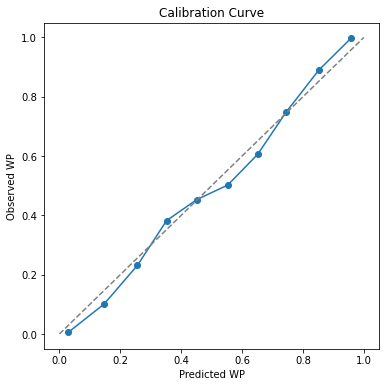

In [122]:
# Compute calibration, Brier score, reliability/resolution
# Bin predicted WP
bins = np.linspace(0, 1, 11)
wp_bin = pd.cut(pbp_fourth_test_tuned['wp_pred'], bins, include_lowest=True)

# Aggregate by bin
cal_table = pbp_fourth_test_tuned.groupby(wp_bin).agg(
    wp_pred_mean=('wp_pred', 'mean'),
    win_rate=('win_actual', 'mean'),
    count=('win_actual', 'count')
).reset_index()

# Brier score
brier = np.mean((pbp_fourth_test_tuned['wp_pred'] - pbp_fourth_test_tuned['win_actual'])**2)

# Reliability and resolution
N = len(pbp_fourth_test_tuned)
reliability = np.sum(cal_table['count'] / N * (cal_table['wp_pred_mean'] - cal_table['win_rate'])**2)
resolution = np.sum(cal_table['count'] / N * (cal_table['win_rate'] - pbp_fourth_test_tuned['win_actual'].mean())**2)
uncertainty = np.mean(pbp_fourth_test_tuned['win_actual']) * (1 - np.mean(pbp_fourth_test_tuned['win_actual']))
brier_check = reliability - resolution + uncertainty

# Print results
print(f"Brier score: {brier:.5f}")
print(f"Reliability: {reliability:.5f}")
print(f"Resolution: {resolution:.5f}")
print(f"Uncertainty: {uncertainty:.5f}")
print(f"Brier check (reliability - resolution + uncertainty): {brier_check:.5f}")

# Plot calibration
x = cal_table['wp_pred_mean'].values.ravel()  # ensures 1D
y = cal_table['win_rate'].values.ravel()     # ensures 1D

plt.figure(figsize=(6,6))
plt.plot(x, y, marker='o')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('Predicted WP')
plt.ylabel('Observed WP')
plt.title('Calibration Curve')
plt.show()

In [123]:
cal_table

,wp_pred,wp_pred_mean,win_rate,count
0,"(-0.001, 0.1]",0.029602,0.006024,498
1,"(0.1, 0.2]",0.146559,0.100746,268
2,"(0.2, 0.3]",0.256024,0.230978,368
3,"(0.3, 0.4]",0.351902,0.382151,437
4,"(0.4, 0.5]",0.451525,0.453382,547
5,"(0.5, 0.6]",0.553040,0.502222,450
6,"(0.6, 0.7]",0.651407,0.605960,302
7,"(0.7, 0.8]",0.744431,0.747634,317
8,"(0.8, 0.9]",0.851679,0.889344,244
9,"(0.9, 1.0]",0.958013,0.997326,374


In [124]:
bins = np.linspace(0, 1, 11)
calibration_df = pd.DataFrame(index=pd.IntervalIndex.from_tuples([(round(bins[i],2), round(bins[i+1],2)) for i in range(len(bins)-1)]))

# Function to compute empirical win fraction per bin
def empirical_win_fraction(pred_col):
    return pbp_fourth_test_tuned.groupby(pd.cut(pbp_fourth_test_tuned[pred_col], bins=bins))['win_actual'].mean()

# Compute results for each play type
calibration_df['ewp_punt'] = round(empirical_win_fraction('ewp_punt'),3)
calibration_df['ewp_fg'] = round(empirical_win_fraction('ewp_fg'),3)
calibration_df['ewp_go_adj'] = round(empirical_win_fraction('ewp_go_adj'),3)

# Bins indicate predicted wp bin; columns are how often a team actually won in that predicted wp bin
calibration_df

,ewp_punt,ewp_fg,ewp_go_adj
"(0.0, 0.1]",0.017,0.019,0.008
"(0.1, 0.2]",0.092,0.158,0.111
"(0.2, 0.3]",0.252,0.278,0.237
"(0.3, 0.4]",0.399,0.405,0.401
"(0.4, 0.5]",0.454,0.513,0.461
"(0.5, 0.6]",0.496,0.542,0.504
"(0.6, 0.7]",0.643,0.686,0.684
"(0.7, 0.8]",0.744,0.748,0.722
"(0.8, 0.9]",0.905,0.913,0.902
"(0.9, 1.0]",0.997,0.994,1.000


In [125]:
ewp_columns = ['ewp_punt', 'ewp_fg', 'ewp_go_adj']

# Boolean mask of violations
violation_mask = (pbp_fourth_test_tuned[ewp_columns] < 0) | (pbp_fourth_test_tuned[ewp_columns] > 1)

# Count violations per column
violations = violation_mask.sum()

if violations.sum() == 0:
    print("No EWP violations detected.")
else:
    print("Violations detected:")
    print(violations)
    print(pbp_fourth_test_tuned[violation_mask.any(axis=1)].head())

No EWP violations detected.


In [126]:
state = pbp_fourth_test_tuned[wp_features]
state_flipped = state.copy()
state_flipped["score_differential"] *= -1
state_flipped[["posteam_timeouts_remaining","defteam_timeouts_remaining"]] = (
    state_flipped[["defteam_timeouts_remaining","posteam_timeouts_remaining"]].values
)
state_flipped["yardline_100"] = 100 - state_flipped["yardline_100"]
state_flipped["score_time_ratio"] = state_flipped["score_differential"].abs() / (state_flipped["game_seconds_remaining"] + 1)

wp = wp_symmetric_adjust(state, predict_wp)
wp_flipped = wp_symmetric_adjust(state_flipped, predict_wp)
flip_err = wp + wp_flipped - 1

flip_err.mean()

0.0089705875

In [127]:
# Conditional mean regret
pbp_fourth_test_tuned[pbp_fourth_test_tuned.follow_model == 0].regret_actual.mean()

0.01131674958435927

In [128]:
# Compute regret stats by play type ---
df_disagree = pbp_fourth_test_tuned[pbp_fourth_test_tuned["disagreed"] == True].copy()
regret_by_play = df_disagree.groupby('play_type_actual')['regret_actual'].agg(['mean', 'median'])
df_disagree['regret_actual'] = pd.to_numeric(df_disagree['regret_actual'], errors='coerce')

# Compute stats
regret_by_play = df_disagree.groupby('play_type_actual')['regret_actual'].agg(['size', 'mean', 'median'])
regret_by_play['95th'] = df_disagree.groupby('play_type_actual')['regret_actual'].quantile(0.95)

print("Regret by Play Type:")
regret_by_play

Regret by Play Type:


,size,mean,median,95th
play_type_actual,,,,
field_goal,227,0.009080,0.005418,0.024997
go,462,0.013654,0.008678,0.040700
punt,199,0.008441,0.005149,0.025367


In [129]:
# Regret vs margin for disagreements
disagree_bins = pd.qcut(df_disagree["decision_margin"], q=10, duplicates="drop")
regret_by_margin = df_disagree.groupby(disagree_bins)["regret_actual"].agg(
    mean="mean",
    p95=lambda x: np.percentile(x, 95),
    count="count"
)
print("Regret vs Decision Margin (Disagreements)")
display(regret_by_margin)

# Bin decision margin
pbp_fourth_test_tuned["margin_bin"] = pd.qcut(pbp_fourth_test_tuned["decision_margin"], 10)
follow_by_margin = pbp_fourth_test_tuned.groupby("margin_bin").agg(
    follow_rate=("follow_model", "mean"),
    count=("follow_model", "size")
)
print("Follow Model Rate vs Decision Margin")
follow_by_margin

Regret vs Decision Margin (Disagreements)


,mean,p95,count
decision_margin,,,
"(-0.001, 0.000632]",0.000532,0.002939,89
"(0.000632, 0.00175]",0.001464,0.002920,89
"(0.00175, 0.00311]",0.003251,0.005718,89
"(0.00311, 0.00483]",0.004323,0.005161,88
"(0.00483, 0.00679]",0.006818,0.011140,89
"(0.00679, 0.00906]",0.008001,0.009012,89
"(0.00906, 0.0116]",0.011019,0.015779,88
"(0.0116, 0.0155]",0.013848,0.015400,89
"(0.0155, 0.0248]",0.019521,0.024320,89


Follow Model Rate vs Decision Margin


,follow_rate,count
margin_bin,,
"(-0.001, 0.00214]",0.477690,381
"(0.00214, 0.0047]",0.605263,380
"(0.0047, 0.00772]",0.643045,381
"(0.00772, 0.0113]",0.673684,380
"(0.0113, 0.0157]",0.711286,381
"(0.0157, 0.0213]",0.850000,380
"(0.0213, 0.0287]",0.873684,380
"(0.0287, 0.0389]",0.923885,381
"(0.0389, 0.0531]",0.955263,380


In [130]:
df_disagree[(df_disagree.decision_margin > .05)].groupby('recommended_play')['regret_actual'].agg(['mean', 'size'])

,mean,size
recommended_play,,
field_goal,0.074531,7
go,0.061711,3
punt,0.094701,10


In [131]:
test = pbp_fourth_test_tuned[pbp_fourth_test_tuned.season == 2024]

labels = ["punt", "field_goal", "go"]

cm_df = test[["play_type_actual", "recommended_play"]].dropna()

cm = confusion_matrix(
    cm_df["play_type_actual"].astype(str),
    cm_df["recommended_play"].astype(str),
    labels=labels
)

confusion = pd.DataFrame(
    cm,
    index=pd.Index(labels, name="Actual"),
    columns=pd.Index(labels, name="Recommended")
)

confusion

Recommended,punt,field_goal,go
Actual,,,
punt,1740,49,150
field_goal,82,833,145
go,284,178,344


In [132]:
confusion_norm = confusion.div(confusion.sum(axis=1), axis=0)
round(confusion_norm,4)

Recommended,punt,field_goal,go
Actual,,,
punt,0.8974,0.0253,0.0774
field_goal,0.0774,0.7858,0.1368
go,0.3524,0.2208,0.4268


In [133]:
cols = [
    "regret_actual",
    "follow_model",
    "go_success_penalty",
    "go_fail_distance_penalty",
    "go_field_position_penalty"
]

corr = pbp_fourth_test_tuned[cols].corr()
corr

,regret_actual,follow_model,go_success_penalty,go_fail_distance_penalty,go_field_position_penalty
regret_actual,1.000000,-0.545247,-0.155794,-0.048941,-0.108523
follow_model,-0.545247,1.000000,0.331117,0.249759,0.215580
go_success_penalty,-0.155794,0.331117,1.000000,0.456461,0.110069
go_fail_distance_penalty,-0.048941,0.249759,0.456461,1.000000,0.129906
go_field_position_penalty,-0.108523,0.215580,0.110069,0.129906,1.000000
